### Impor Library dan Paket yang Diperlukan

In [117]:
!pip install -q pmdarima
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

### Mengunduh Dataset

In [118]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ihelon/coffee-sales")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ihelon/coffee-sales/versions/13


In [119]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/ihelon/coffee-sales/versions/13/index.csv")

### Data Understanding

In [120]:
# Menampilkan seluruh data yang ada di dalam dataframe
df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte
...,...,...,...,...,...,...
1912,2024-10-13,2024-10-13 13:34:25.907,card,ANON-0000-0000-0650,25.96,Cortado
1913,2024-10-13,2024-10-13 17:53:20.717,card,ANON-0000-0000-0507,35.76,Latte
1914,2024-10-13,2024-10-13 17:54:22.430,card,ANON-0000-0000-0507,35.76,Latte
1915,2024-10-13,2024-10-13 18:22:58.819,card,ANON-0000-0000-0753,35.76,Cappuccino


In [121]:
# Menampilkan informasi umum tentang dataframe, termasuk jumlah baris, kolom, tipe data, dan jumlah data non-null per kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1917 non-null   object 
 1   datetime     1917 non-null   object 
 2   cash_type    1917 non-null   object 
 3   card         1828 non-null   object 
 4   money        1917 non-null   float64
 5   coffee_name  1917 non-null   object 
dtypes: float64(1), object(5)
memory usage: 90.0+ KB


In [122]:
# Menampilkan statistik deskriptif dari data numerik pada dataframe
df.describe()

,money
count,1917.000000
mean,31.560584
std,5.260794
min,18.120000
25%,27.920000
50%,32.820000
75%,35.760000
max,40.000000


In [123]:
# Menampilkan jumlah nilai yang hilang (null) pada setiap kolom
df.isnull().sum()

,0
date,0
datetime,0
cash_type,0
card,89
money,0
coffee_name,0


In [124]:
# Menampilkan jumlah duplikasi dalam dataset
df.duplicated().sum()

0

Secara keseluruhan, bagian Data Understanding ini akan memberikan gambaran menyeluruh tentang struktur data, adanya data yang hilang atau duplikat, serta statistik dasar yang akan membantu dalam proses pembersihan dan persiapan data untuk tahap modeling.

### Data Preparation


Kode dibawah ini bertujuan untuk memastikan bahwa dataset memiliki tanggal yang lengkap dari tanggal paling awal hingga paling akhir, termasuk tanggal tanpa transaksi. Pertama, kode membuat rentang tanggal lengkap (date_range) dan menyimpannya dalam DataFrame complete_dates. Kemudian, dataset asli dikelompokkan berdasarkan tanggal dan dihitung jumlah transaksi per tanggal, disimpan dalam DataFrame df_by_date. Selanjutnya, kedua DataFrame tersebut digabung menggunakan left join untuk memastikan semua tanggal tercakup, meskipun tidak ada transaksi pada beberapa tanggal. Terakhir, nilai NaN pada tanggal tanpa transaksi diganti dengan nol untuk menjaga integritas data saat analisis lebih lanjut.

Hasilnya adalah DataFrame df_complete yang berisi setiap tanggal beserta jumlah transaksi harian, dengan nilai nol untuk hari tanpa transaksi.

In [125]:
# Mengonversi kolom 'date' menjadi tipe datetime agar lebih mudah dalam manipulasi data waktu
df["date"] = pd.to_datetime(df["date"])

# Membuat rentang tanggal dari tanggal terendah hingga tertinggi pada data yang ada
date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

# Membuat DataFrame baru dengan rentang tanggal lengkap untuk mengisi data yang mungkin hilang
complete_dates = pd.DataFrame(date_range, columns=["date"])

# Mengelompokkan data berdasarkan 'date' dan menghitung jumlah transaksi (cups) per hari
df_by_date = df.groupby("date").agg({"money": ["count"]}).reset_index()

# Mengganti nama kolom menjadi 'cups' untuk menunjukkan jumlah transaksi/hari
df_by_date.columns = ["date", "cups"]

# Menggabungkan dataframe 'complete_dates' dengan 'df_by_date' untuk memastikan semua tanggal ada,
# dan mengisi tanggal tanpa transaksi dengan 0
df_complete = pd.merge(complete_dates, df_by_date, on="date", how="left")
df_complete.fillna(0, inplace=True)

# Menampilkan dataframe hasil untuk memeriksa apakah ada missing date yang telah terisi
df_complete.head()

,date,cups
0,2024-03-01,11.0
1,2024-03-02,7.0
2,2024-03-03,10.0
3,2024-03-04,4.0
4,2024-03-05,9.0


<Axes: >

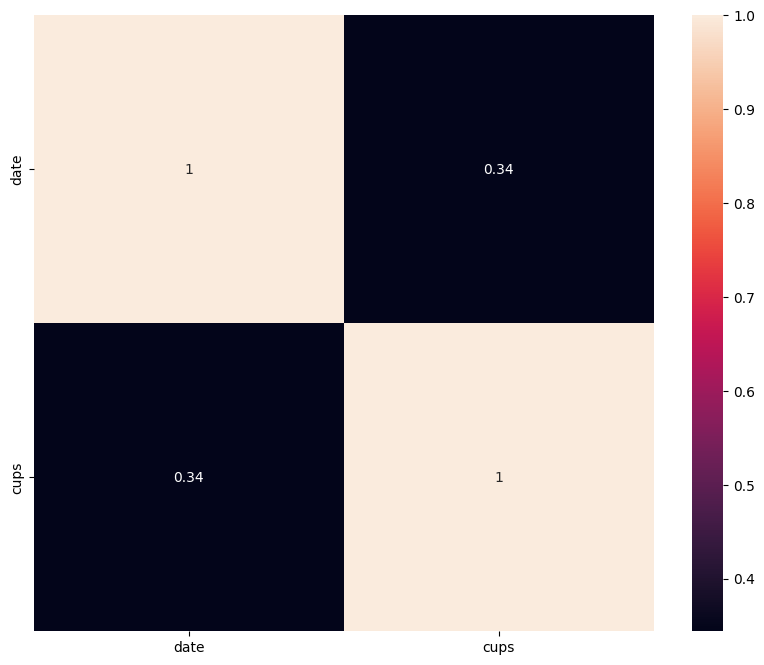

In [126]:
# Menghitung korelasi antar kolom pada dataframe df_complete
corr = df_complete.corr()

# Menyusun plot heatmap untuk matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)

Terdapat korelasi antara kolom money dan cups, itu menunjukkan bahwa ada hubungan total uang yang dibelanjakan dengan jumlah kopi yang terjual.

#### Split data menjadi set pelatihan dan pengujian:

In [127]:
# Menentukan ukuran data pengujian (test size)
test_size = 7

# Menentukan ukuran data pelatihan (train size)
train_size = df_complete.shape[0] - test_size

# Memisahkan data menjadi dua set: df_train untuk pelatihan dan df_test untuk pengujian
df_train = df_complete.iloc[:train_size]
df_test = df_complete.iloc[train_size:]

# Menyiapkan list untuk menyimpan hasil evaluasi (metrics)
metrics = []

Kode ini memisahkan dataset menjadi dua bagian: data pelatihan (df_train) dan data pengujian (df_test), yang digunakan untuk melatih dan menguji model secara terpisah.
Ini adalah langkah yang penting untuk menghindari overfitting dan untuk memvalidasi model dengan data yang tidak terlihat sebelumnya.

(0.0, 27.3)

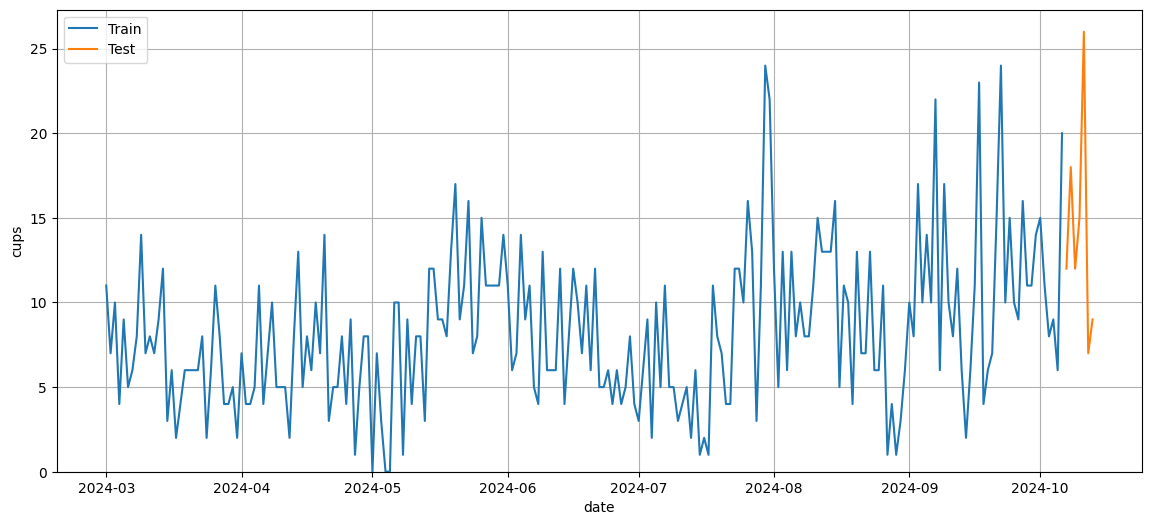

In [128]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
plt.grid()
plt.ylim(0)

Kode ini membuat grafik garis untuk memvisualisasikan data pelatihan dan pengujian secara terpisah, yang memungkinkan kita untuk melihat tren penjualan cangkir selama periode waktu tertentu dan membandingkan pola penjualan antara data pelatihan dan pengujian.
Dengan menggunakan grid dan pengaturan batas Y, grafik ini lebih mudah dibaca dan memberi gambaran yang lebih jelas tentang tren data.

### Modeling

#### ARIMA

In [129]:
# Menentukan parameter p, d, q untuk model ARIMA
p, d, q = 5, 0, 5  # p = order autoregressive, d = order differencing, q = order moving average

# Membuat model ARIMA dengan data pelatihan 'cups' dan parameter yang sudah ditentukan
model = ARIMA(df_train['cups'], order=(p, d, q))

# Melatih model ARIMA dengan data pelatihan
model_fit = model.fit()  # Model ARIMA di-fit dengan data pelatihan untuk mendapatkan parameter terbaik

# Menggunakan model yang sudah dilatih untuk memprediksi nilai di data pengujian
test_predictions= model_fit.forecast(steps=len(df_test)).values  # Prediksi untuk data pengujian (steps = panjang data test)

# Menyimpan hasil prediksi dalam kolom baru 'arima_pred' di data pengujian
df_test["arima_pred"] = test_predictions # Menambahkan prediksi model ke df_test untuk analisis lebih lanjut

- Menetapkan nilai untuk parameter ARIMA (p, d, dan q).
- Membangun model ARIMA menggunakan data pelatihan (df_train['cups']) dengan parameter yang sudah ditetapkan.
- Melatih model menggunakan fungsi fit() untuk mendapatkan parameter yang optimal.
- Menggunakan model yang telah dilatih untuk menghasilkan prediksi sebanyak data pada set pengujian.
- Menyimpan prediksi ke dalam kolom baru di df_test agar bisa dibandingkan dengan nilai aktual di data pengujian.

In [131]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "ARIMA", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 6.346739146140698


#### AUTO SARIMAX

In [132]:
# Membangun model AutoARIMA dengan parameter untuk data musiman
model = auto_arima(
    df_train['cups'],  # Menggunakan data pelatihan 'cups' untuk membangun model
    seasonal=True,  # Menentukan bahwa data memiliki komponen musiman
    m=7,  # Menentukan panjang musim (7 hari dalam seminggu)
    trace=True,  # Menampilkan proses pencarian parameter terbaik (trace)
    error_action='ignore',  # Mengabaikan kesalahan selama pencarian parameter
    suppress_warnings=True,  # Menekan peringatan yang tidak perlu selama pelatihan
)

# Menggunakan model AutoARIMA yang sudah dilatih untuk memprediksi data pengujian
test_predictions = model.predict(n_periods=len(df_test)).values  # n_periods = panjang data test untuk prediksi

# Menyimpan hasil prediksi dalam kolom baru 'auto_sarimax_pred' di data pengujian
df_test["auto_sarimax_pred"] = test_predictions # Menambahkan prediksi model ke df_test untuk analisis lebih lanjut

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1265.843, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1363.815, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1310.397, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1258.237, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1361.828, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1258.463, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1260.066, Time=0.92 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=1260.081, Time=0.67 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1258.375, Time=0.93 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=1261.533, Time=4.87 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1363.102, Time=0.15 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1260.218, Time=0.55 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=1260.217, Time=0.91 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1310.151, Time=0.68 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

In [133]:
# Menyimpan hasil prediksi dalam kolom baru 'auto_sarimax_pred' di data pengujian
df_test["auto_sarimax_pred"] = test_predictions # Menambahkan prediksi model ke df_test untuk analisis lebih lanjut

- Membangun model AutoARIMA: Kode ini menggunakan fungsi auto_arima untuk membangun model yang mengoptimalkan parameter ARIMA secara otomatis, termasuk komponen musiman. Parameter m=7 menandakan data musiman dengan periode 7 hari (misalnya, pola mingguan).
- Pengaturan tambahan: trace=True menampilkan proses pencarian parameter terbaik selama pelatihan, sementara error_action='ignore' dan suppress_warnings=True digunakan untuk mengabaikan kesalahan atau peringatan selama proses pelatihan.
- Prediksi dengan model AutoARIMA: Setelah model dilatih, fungsi predict(n_periods) digunakan untuk memprediksi nilai pada data pengujian (df_test) selama periode yang diperlukan (n_periods).
- Menyimpan hasil prediksi: Prediksi yang dihasilkan disimpan dalam kolom baru auto_sarimax_pred pada data pengujian (df_test) agar bisa dianalisis lebih lanjut.

In [135]:
mae = mean_absolute_error(df_test["cups"], test_predictions_sarimax)
metrics.append({"model": "Auto SARIMAX", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 4.389472442043012


### Evaluasi & Visualisasi Model

#### ARIMA

(0.0, 27.3)

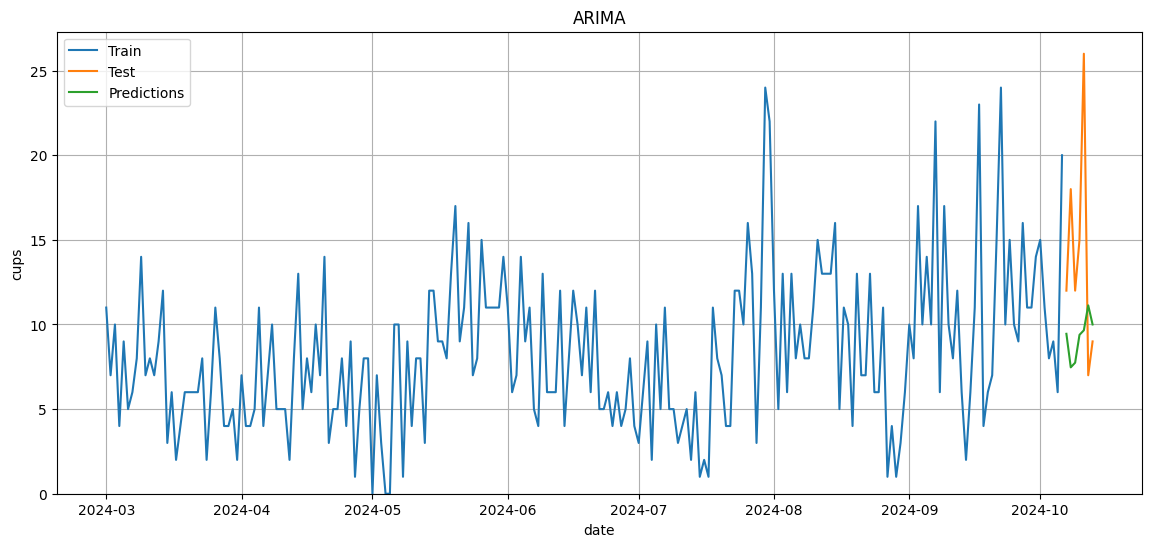

In [136]:
# Visualisasi data train, test, dan prediksi ARIMA
plt.figure(figsize=(14, 6))  # Menentukan ukuran grafik
sns.lineplot(data=df_train, y="cups", x="date", label="Train")  # Menampilkan data training
sns.lineplot(data=df_test, y="cups", x="date", label="Test")  # Menampilkan data testing
sns.lineplot(data=df_test, y="arima_pred", x="date", label="Predictions")  # Menampilkan hasil prediksi ARIMA
plt.title('ARIMA')  # Menambahkan judul grafik
plt.grid()  # Menambahkan grid untuk memudahkan visualisasi
plt.ylim(0)  # Membatasi sumbu y mulai dari 0

Pada bagian ini, grafik garis menampilkan data pelatihan (Train), data pengujian (Test), dan hasil prediksi model ARIMA (Predictions) berdasarkan data pengujian.
Fungsi sns.lineplot() digunakan untuk menggambar grafik garis dengan label yang sesuai untuk membedakan setiap data (Train, Test, dan Prediksi).

#### Auto SARIMAX

(0.0, 27.3)

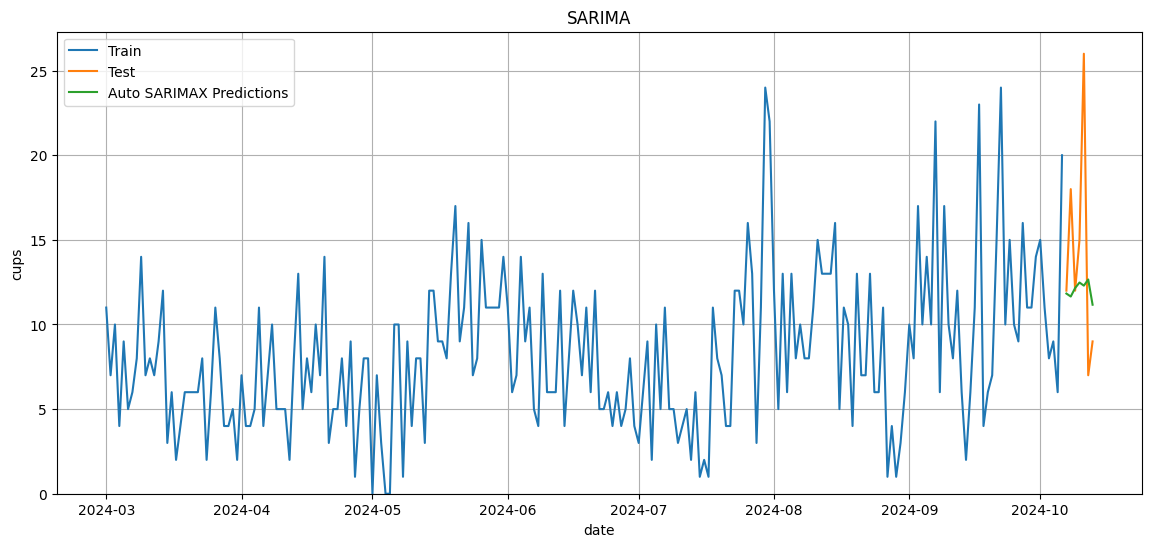

In [137]:
# Visualisasi data train, test, dan prediksi Auto SARIMAX
plt.figure(figsize=(14, 6))  # Menentukan ukuran grafik
sns.lineplot(data=df_train, y="cups", x="date", label="Train")  # Menampilkan data training
sns.lineplot(data=df_test, y="cups", x="date", label="Test")  # Menampilkan data testing
sns.lineplot(data=df_test, y="auto_sarimax_pred", x="date", label="Auto SARIMAX Predictions")  # Menampilkan hasil prediksi Auto SARIMAX
plt.title('SARIMA')  # Menambahkan judul grafik
plt.grid()  # Menambahkan grid untuk memudahkan visualisasi
plt.ylim(0)  # Membatasi sumbu y mulai dari 0

Sekali lagi, grafik yang serupa digambar, tetapi kali ini menggunakan model Auto SARIMAX untuk memprediksi data pengujian. auto_sarimax_pred menampilkan hasil prediksi yang dihasilkan oleh model tersebut.
Ini memberi gambaran bagaimana model Auto SARIMAX dibandingkan dengan model ARIMA dalam memprediksi jumlah penjualan.

#### ARIMA VS Auto SARIMAX

In [141]:
df_test

,date,cups,arima_pred,auto_sarimax_pred
220,2024-10-07,12.0,9.449440,11.827671
221,2024-10-08,18.0,7.467207,11.652599
222,2024-10-09,12.0,7.742756,12.154289
223,2024-10-10,15.0,9.388199,12.479789
224,2024-10-11,26.0,9.658140,12.295389
225,2024-10-12,7.0,11.130348,12.659409
226,2024-10-13,9.0,10.002568,11.168057


Menampilkan dua kolom prediksi, yaitu dari model ARIMA (arima_pred) dan Auto SARIMAX (auto_sarimax_pred).

<Axes: xlabel='mae', ylabel='model'>

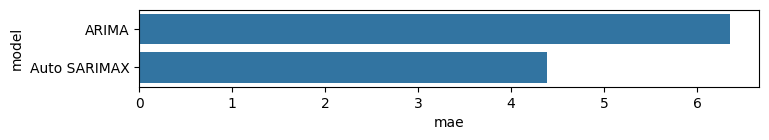

In [140]:
# Membandingkan hasil metrik antara ARIMA dan Auto SARIMAX
df_metrics = pd.DataFrame(metrics)  # Membuat DataFrame dari metrics yang sudah dihitung sebelumnya

# Visualisasi perbandingan metrik MAE antara ARIMA dan Auto SARIMAX
plt.figure(figsize=(8, 1 * df_metrics.shape[0] // 2))  # Mengatur ukuran grafik barplot
sns.barplot(data=df_metrics, y="model", x="mae")  # Menampilkan barplot berdasarkan MAE dari masing-masing model

Bagian ini membandingkan kinerja model ARIMA dan Auto SARIMAX menggunakan metrik Mean Absolute Error (MAE).
df_metrics berisi data metrik (seperti MAE) dari kedua model. Barplot digunakan untuk menggambarkan hasilnya dengan jelas, dengan mae sebagai sumbu X dan model sebagai sumbu Y.

Perbandingan MAE:

ARIMA: Memberikan MAE yang menggambarkan rata-rata kesalahan absolut.
Auto SARIMAX: Diharapkan memberikan MAE lebih rendah karena model ini mengoptimalkan parameter musiman.
Visualisasi Hasil Prediksi:

Grafik prediksi menunjukkan perbedaan antara model ARIMA dan Auto SARIMAX.
Model dengan prediksi lebih mendekati data aktual dianggap lebih baik.
Perbandingan MAE:

Perbandingan MAE antara kedua model dapat dilakukan untuk menentukan model terbaik berdasarkan nilai MAE yang lebih rendah.
Kesimpulan:

Model dengan MAE lebih rendah lebih baik dalam memprediksi penjualan. Pilihan model juga mempertimbangkan kesederhanaan dan biaya komputasi.